In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

from trustee import ClassificationTrustee

In [2]:
attacker_ips = {
    '169.231.210.93',
    '169.231.28.232',
    '169.231.123.195',
    '169.231.172.165',
    '169.231.11.193',
    '169.231.8.190',
    '169.231.10.199',
}

In [3]:
campus_dataset = pd.read_csv('campus_dataset_1.csv')
campus_dataset['Class'] = 0
campus_dataset.loc[campus_dataset['Src IP'].isin(attacker_ips), 'Class'] = 1

print(len(campus_dataset))
ttl_data = pd.read_csv('campus_ttl_1.csv')
campus_dataset = campus_dataset.merge(ttl_data, on="Flow ID", how='left')
len(campus_dataset)

6681


6681

In [4]:
campus_dataset = campus_dataset.drop([
    'Flow ID',
    'Src IP',
    'Dst IP',
    'Timestamp', 
    'Protocol',    # always tcp
    'Label',       # empty
], axis=1)

In [5]:
azure_dataset = pd.read_csv('azure_dataset_1.csv')
azure_dataset['Class'] = 0
azure_dataset.loc[azure_dataset['Src IP'].isin(attacker_ips), 'Class'] = 1
ttl_df_azure = pd.read_csv('azure_ttl_1.csv')
azure_dataset = azure_dataset.merge(ttl_df_azure, on="Flow ID", how='left')
azure_dataset = azure_dataset.replace([np.inf, -np.inf], np.nan)
azure_dataset = azure_dataset.dropna(axis=0)

In [6]:
attacker_ips = {
    '157.245.108.149',
    '34.214.149.122',
}

multicloud_dataset = pd.read_csv('multicloud_dataset_1.csv')
multicloud_dataset['Class'] = 0
multicloud_dataset.loc[multicloud_dataset['Src IP'].isin(attacker_ips), 'Class'] = 1
ttl_df_multicloud = pd.read_csv('multicloud_ttl_1.csv')
multicloud_dataset = multicloud_dataset.merge(ttl_df_multicloud, on="Flow ID", how='left')
multicloud_dataset = multicloud_dataset.replace([np.inf, -np.inf], np.nan)
multicloud_dataset = multicloud_dataset.dropna(axis=0)

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

Train on campus dataset, check on Azure and multicloud

In [8]:
target_variable = 'Class'
features = list(set(campus_dataset.columns) - {target_variable})
x_train = campus_dataset[features]
y_train = campus_dataset[target_variable]
x_test = azure_dataset[features]
y_test = azure_dataset[target_variable]
x_test_2 = multicloud_dataset[features]
y_test_2 = multicloud_dataset[target_variable]

In [9]:
from sklearn.preprocessing import StandardScaler
x_train_scaler = StandardScaler()
x_test_scaler = StandardScaler()
x_test_2_scaler = StandardScaler()

x_train = pd.DataFrame(x_train_scaler.fit_transform(x_train), columns = x_train.columns)
x_test = pd.DataFrame(x_test_scaler.fit_transform(x_test), columns = x_test.columns)
x_test_2 = pd.DataFrame(x_test_2_scaler.fit_transform(x_test_2), columns = x_test_2.columns)

In [10]:
classifiers = [
    MLPClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(),
]

In [11]:
for clf in classifiers:
    print(clf)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_train)
    print("campus dataset training accuracy: ")
    print(metrics.classification_report(y_train, y_pred))

    print("Azure dataset test accuracy: ")
    y_pred = clf.predict(x_test)
    print(metrics.classification_report(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))
    
    print("Multicloud dataset test accuracy: ")
    y_pred = clf.predict(x_test_2)
    print(metrics.classification_report(y_test_2, y_pred))
    print(metrics.confusion_matrix(y_test_2, y_pred))
    print('#' * 10 + '\n')

MLPClassifier()
campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      1067

    accuracy                           1.00      6681
   macro avg       1.00      1.00      1.00      6681
weighted avg       1.00      1.00      1.00      6681

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.76      0.51      0.61       528
           1       0.46      0.73      0.56       307

    accuracy                           0.59       835
   macro avg       0.61      0.62      0.59       835
weighted avg       0.65      0.59      0.59       835

[[267 261]
 [ 84 223]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.97      0.55      0.70      5547
           1       0.18      0.84      0.29       638

    accuracy                           0.58

Let's explore the reasons of this performance

campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      1067

    accuracy                           1.00      6681
   macro avg       1.00      1.00      1.00      6681
weighted avg       1.00      1.00      1.00      6681

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.48      0.53      0.50       528
           1       0.00      0.00      0.00       307

    accuracy                           0.33       835
   macro avg       0.24      0.26      0.25       835
weighted avg       0.30      0.33      0.32       835

[[278 250]
 [307   0]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.86      0.73      0.79      5547
           1       0.00      0.00      0.00       638

    accuracy                           0.65      6185
   ma

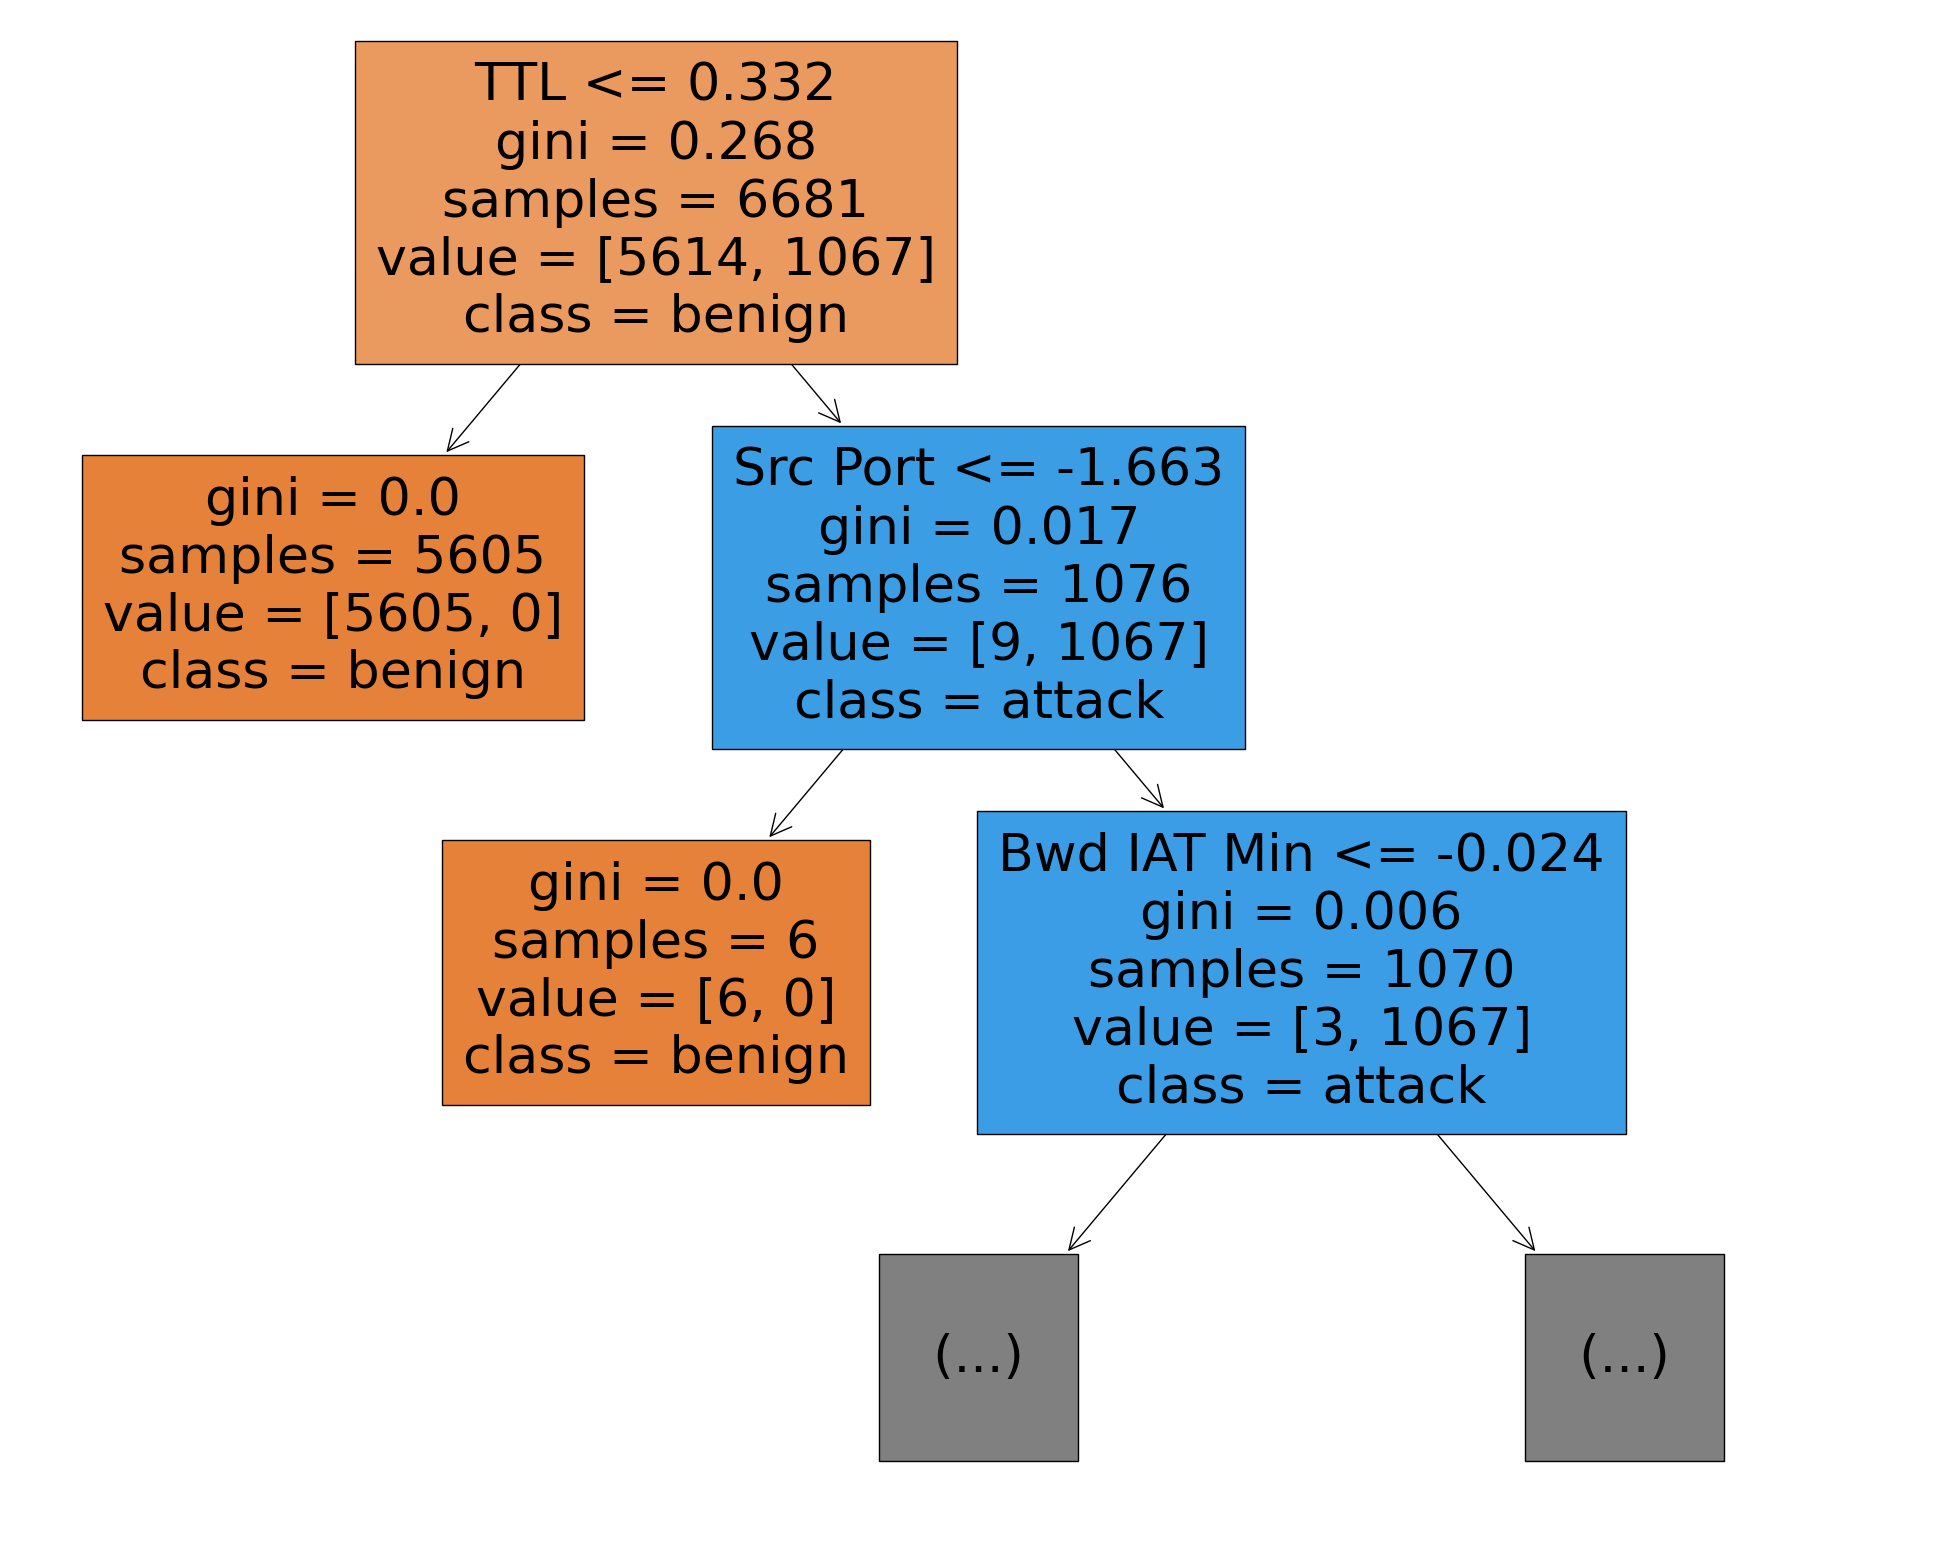

In [12]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)

y_pred = clf.predict(x_train)
print("campus dataset training accuracy: ")
print(metrics.classification_report(y_train, y_pred))

y_pred = clf.predict(x_test)
print("Azure dataset test accuracy: ")
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

y_pred = clf.predict(x_test_2)
print("Multicloud dataset test accuracy: ")
print(metrics.classification_report(y_test_2, y_pred))
print(metrics.confusion_matrix(y_test_2, y_pred))

fig = plt.figure(figsize=(25,20))
_ = plot_tree(clf, feature_names=x_train.columns, class_names=['benign', 'attack'], filled=True, max_depth=2)

The answer is a shortcut in the dataset - usage of TTL as a feature.  
Random forests choose features randomly and therefore often remove TTL from the list and doesn't overfit to it.  

Anyway, TTL is a plain shortcut, let's remove it.

## Out of curiosity - dropping or noising the features
Use information from the future - we know that TTL and Init Win Bytes are or would be shortcuts, so let's add some noise there or drop them and check performance.

In [13]:
target_variable = 'Class'
features = list(set(campus_dataset.columns) - {target_variable})
x_train = campus_dataset[features].copy()
y_train = campus_dataset[target_variable]
x_test = azure_dataset[features]
y_test = azure_dataset[target_variable]
x_test_2 = multicloud_dataset[features]
y_test_2 = multicloud_dataset[target_variable]

In [14]:
x_train.loc[:, 'TTL'] += np.random.randint(-1, 1, [len(x_train)])
x_train.loc[:, 'Bwd Init Win Bytes'] += np.random.randint(-5, 5, [len(x_train)])

In [15]:
x_train = pd.DataFrame(StandardScaler().fit_transform(x_train), columns = x_train.columns)
x_test = pd.DataFrame(StandardScaler().fit_transform(x_test), columns = x_test.columns)
x_test_2 = pd.DataFrame(StandardScaler().fit_transform(x_test_2), columns = x_test_2.columns)

In [16]:
classifiers = [
    MLPClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(),
]
for clf in classifiers:
    print(clf)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_train)
    print("campus dataset training accuracy: ")
    print(metrics.classification_report(y_train, y_pred))

    print("Azure dataset test accuracy: ")
    y_pred = clf.predict(x_test)
    print(metrics.classification_report(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))
    
    print("Multicloud dataset test accuracy: ")
    y_pred = clf.predict(x_test_2)
    print(metrics.classification_report(y_test_2, y_pred))
    print(metrics.confusion_matrix(y_test_2, y_pred))
    print('#' * 10 + '\n')

MLPClassifier()
campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      1067

    accuracy                           1.00      6681
   macro avg       1.00      1.00      1.00      6681
weighted avg       1.00      1.00      1.00      6681

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.47      0.51      0.48       528
           1       0.00      0.00      0.00       307

    accuracy                           0.32       835
   macro avg       0.23      0.25      0.24       835
weighted avg       0.29      0.32      0.31       835

[[267 261]
 [307   0]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.97      0.55      0.70      5547
           1       0.17      0.83      0.29       638

    accuracy                           0.58

### Or let's just drop them

In [17]:
x_train = x_train.drop(['TTL', 'Bwd Init Win Bytes'], axis=1)
x_test = x_test.drop(['TTL', 'Bwd Init Win Bytes'], axis=1)
x_test_2 = x_test_2.drop(['TTL', 'Bwd Init Win Bytes'], axis=1)

In [18]:
classifiers = [
    MLPClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(max_depth=4),
]
for clf in classifiers:
    print(clf)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_train)
    print("campus dataset training accuracy: ")
    print(metrics.classification_report(y_train, y_pred))

    print("Azure dataset test accuracy: ")
    y_pred = clf.predict(x_test)
    print(metrics.classification_report(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))
    
    print("Multicloud dataset test accuracy: ")
    y_pred = clf.predict(x_test_2)
    print(metrics.classification_report(y_test_2, y_pred))
    print(metrics.confusion_matrix(y_test_2, y_pred))
    print('#' * 10 + '\n')

MLPClassifier()
campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5614
           1       0.99      0.79      0.88      1067

    accuracy                           0.96      6681
   macro avg       0.98      0.89      0.93      6681
weighted avg       0.97      0.96      0.96      6681

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       528
           1       0.98      0.93      0.96       307

    accuracy                           0.97       835
   macro avg       0.97      0.96      0.97       835
weighted avg       0.97      0.97      0.97       835

[[523   5]
 [ 20 287]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      5547
           1       0.61      0.98      0.75       638

    accuracy                           0.93

Training score of pruned DT: 1.0
Model explanation global fidelity report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       543
           1       0.97      0.97      0.97       292

    accuracy                           0.98       835
   macro avg       0.98      0.98      0.98       835
weighted avg       0.98      0.98      0.98       835

Model explanation score report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       528
           1       1.00      0.94      0.97       307

    accuracy                           0.98       835
   macro avg       0.98      0.97      0.98       835
weighted avg       0.98      0.98      0.98       835



/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


[Text(0.6, 0.8333333333333334, 'Fwd Act Data Pkts <= -0.153\ngini = 0.248\nsamples = 2618\nvalue = [2239, 379]\nclass = benign'),
 Text(0.4, 0.5, 'RST Flag Count <= 2.133\ngini = 0.11\nsamples = 2377\nvalue = [2238, 139]\nclass = benign'),
 Text(0.2, 0.16666666666666666, 'gini = 0.004\nsamples = 2241\nvalue = [2237, 4]\nclass = benign'),
 Text(0.6, 0.16666666666666666, 'gini = 0.015\nsamples = 136\nvalue = [1, 135]\nclass = attack'),
 Text(0.8, 0.5, 'gini = 0.008\nsamples = 241\nvalue = [1, 240]\nclass = attack')]

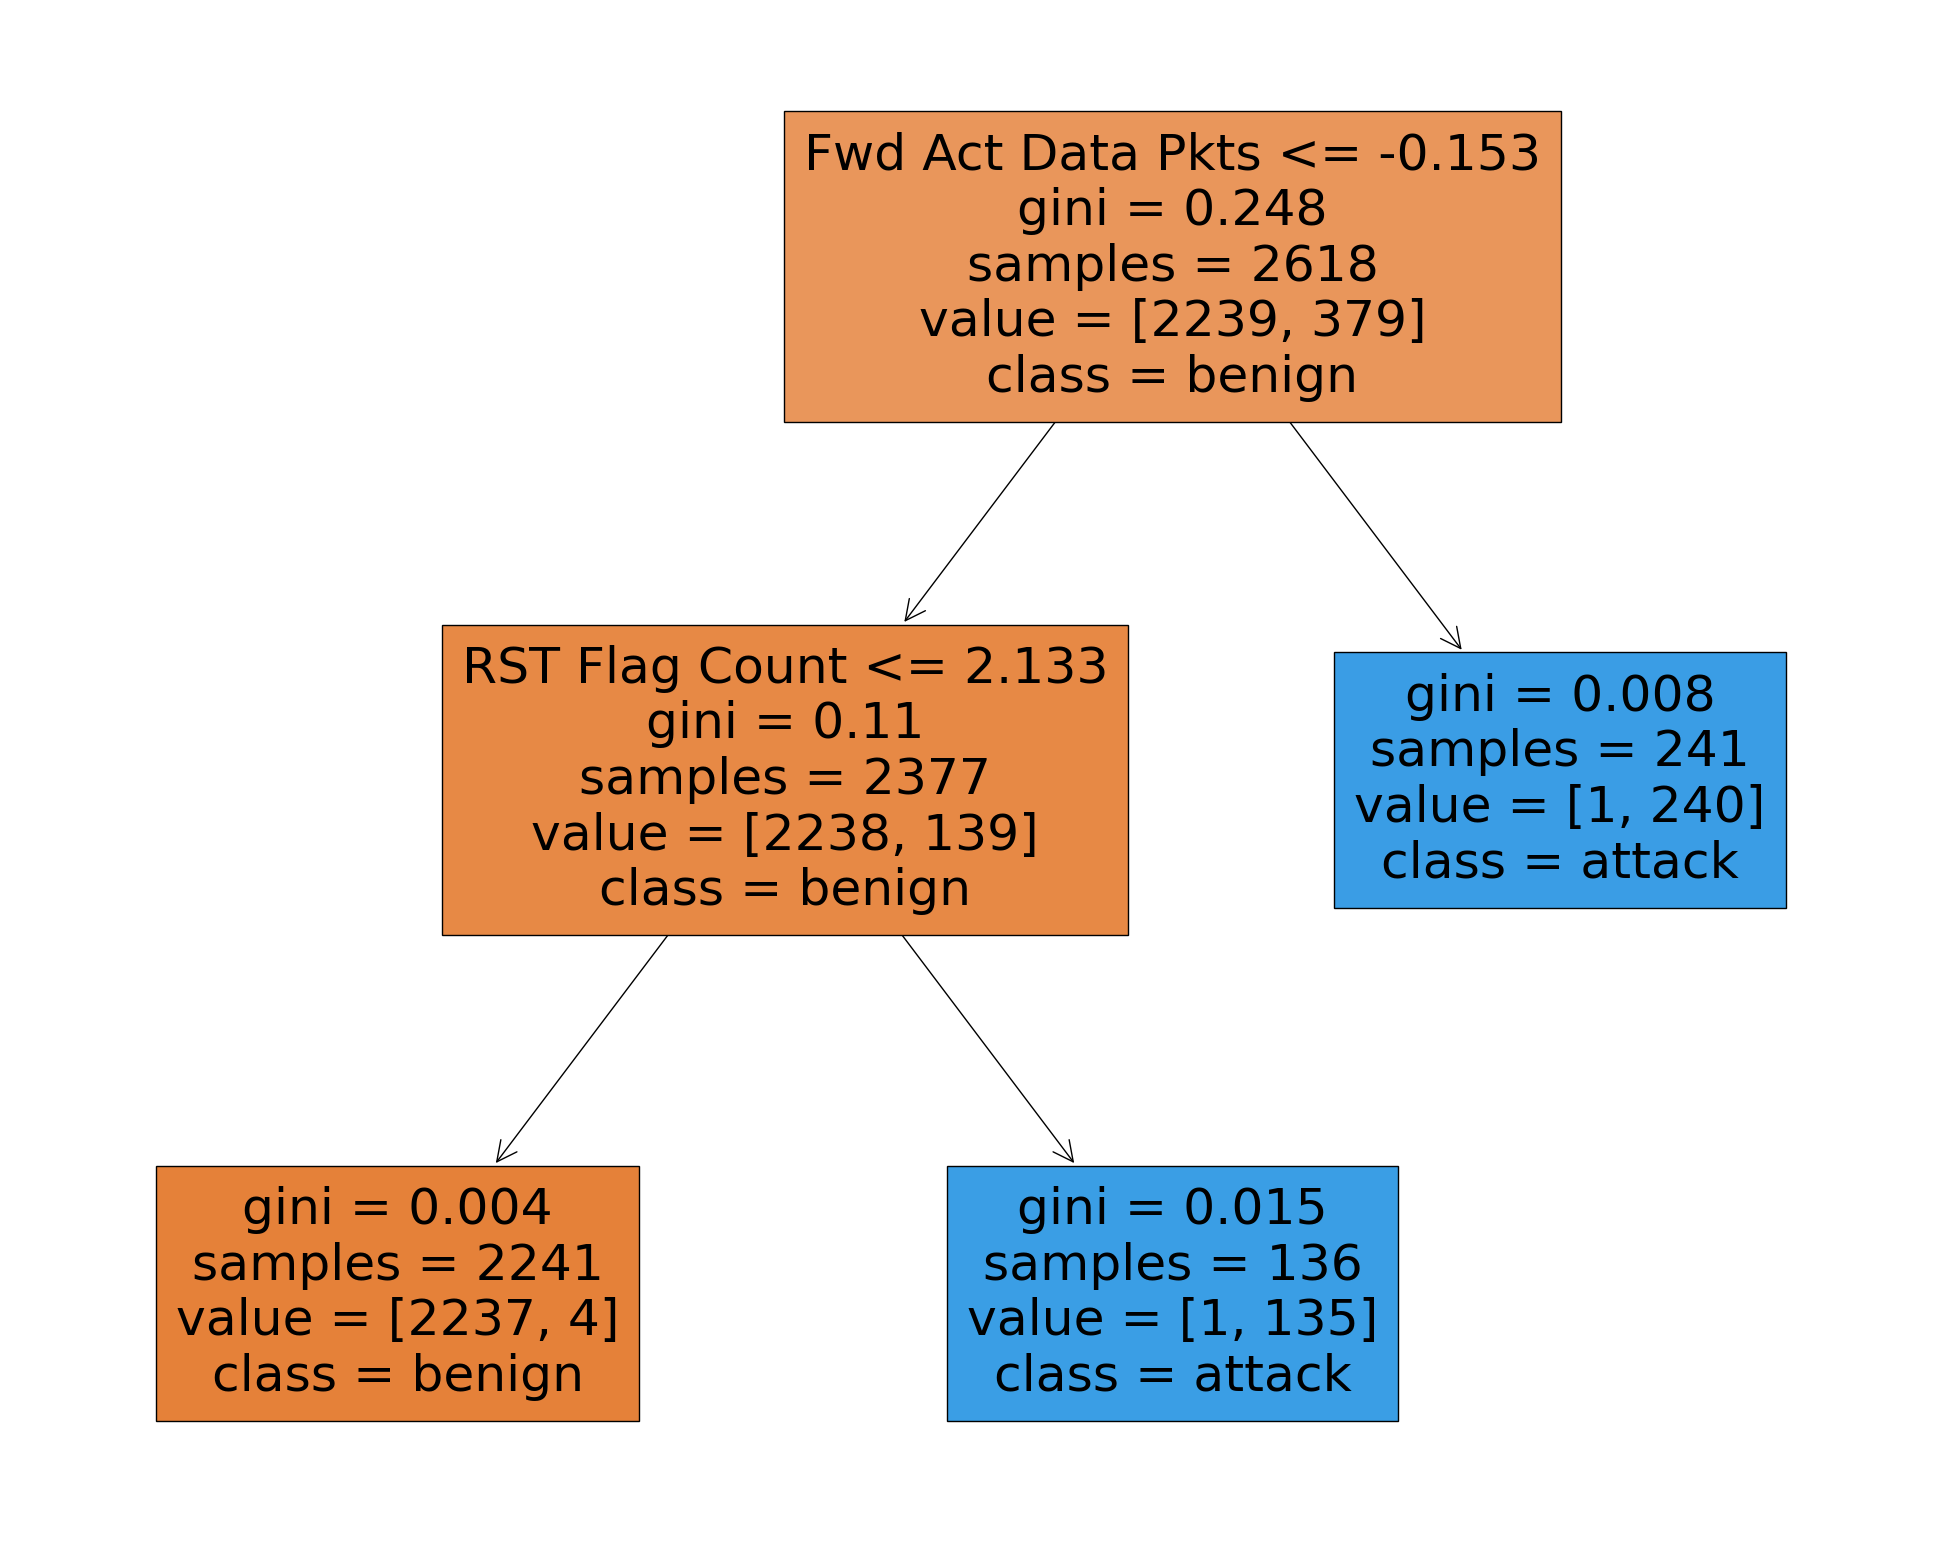

In [19]:
trustee = ClassificationTrustee(expert=classifiers[0])
trustee.fit(x_train, y_train, num_iter=10, num_stability_iter=3, samples_size=0.8)

_, dt, _, score = trustee.explain()
print(f"Training score of pruned DT: {score}")
dt_y_pred = dt.predict(x_test)

print("Model explanation global fidelity report:")
print(metrics.classification_report(classifiers[0].predict(x_test), dt_y_pred))
print("Model explanation score report:")
print(metrics.classification_report(y_test, dt_y_pred))

fig = plt.figure(figsize=(25,20))
plot_tree(dt, feature_names=x_train.columns, class_names=['benign', 'attack'], filled=True, max_depth=3)

### Checking SMOTE

In [20]:
import smote_variants as sv

In [21]:
target_variable = 'Class'
features = list(set(campus_dataset.columns) - {target_variable})
x_train = campus_dataset[features].copy()
y_train = campus_dataset[target_variable]
x_test = azure_dataset[features]
y_test = azure_dataset[target_variable]
x_test_2 = multicloud_dataset[features]
y_test_2 = multicloud_dataset[target_variable]

In [22]:
from sklearn.preprocessing import StandardScaler

x_train = pd.DataFrame(StandardScaler().fit_transform(x_train), columns = x_train.columns)
x_test = pd.DataFrame(StandardScaler().fit_transform(x_test), columns = x_test.columns)
x_test_2 = pd.DataFrame(StandardScaler().fit_transform(x_test_2), columns = x_test_2.columns)

In [23]:
oversampler = sv.SMOTE()
X_samp, y_samp = oversampler.sample(x_train.to_numpy(), y_train.to_numpy())

classifiers = [
    MLPClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(max_depth=4),
]
for clf in classifiers:
    print(clf)
    clf.fit(X_samp, y_samp)
    y_pred = clf.predict(X_samp)
    print("campus dataset training accuracy: ")
    print(metrics.classification_report(y_samp, y_pred))

    print("Azure dataset test accuracy: ")
    y_pred = clf.predict(x_test)
    print(metrics.classification_report(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))
    
    print("Multicloud dataset test accuracy: ")
    y_pred = clf.predict(x_test_2)
    print(metrics.classification_report(y_test_2, y_pred))
    print(metrics.confusion_matrix(y_test_2, y_pred))
    print('#' * 10 + '\n')

2023-04-06 15:48:23,627:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': None, 'class_name': 'SMOTE'}")
2023-04-06 15:48:23,628:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-04-06 15:48:23,629:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2023-04-06 15:48:23,650:INFO:SMOTE: simplex sampling with n_dim 2


MLPClassifier()
campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      5614

    accuracy                           1.00     11228
   macro avg       1.00      1.00      1.00     11228
weighted avg       1.00      1.00      1.00     11228

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.60      0.50      0.54       528
           1       0.33      0.42      0.37       307

    accuracy                           0.47       835
   macro avg       0.46      0.46      0.46       835
weighted avg       0.50      0.47      0.48       835

[[264 264]
 [177 130]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.97      0.55      0.70      5547
           1       0.17      0.83      0.29       638

    accuracy                           0.58

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      5614

    accuracy                           1.00     11228
   macro avg       1.00      1.00      1.00     11228
weighted avg       1.00      1.00      1.00     11228

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.28      0.22      0.25       528
           1       0.00      0.00      0.00       307

    accuracy                           0.14       835
   macro avg       0.14      0.11      0.12       835
weighted avg       0.17      0.14      0.16       835

[[117 411]
 [307   0]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.83      0.55      0.66      5547
           1       0.00      0.00      0.00       638

    accuracy                           0.49      6185
   ma

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      5614

    accuracy                           1.00     11228
   macro avg       1.00      1.00      1.00     11228
weighted avg       1.00      1.00      1.00     11228

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.82      0.22      0.34       528
           1       0.41      0.92      0.56       307

    accuracy                           0.47       835
   macro avg       0.61      0.57      0.45       835
weighted avg       0.67      0.47      0.42       835

[[114 414]
 [ 25 282]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.99      0.42      0.59      5547
           1       0.16      0.98      0.28       638

    accuracy                           0.48      6185
   ma

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


### SYMPROD SMOTE

In [24]:
oversampler = sv.SYMPROD()
X_samp, y_samp = oversampler.sample(x_train.to_numpy(), y_train.to_numpy())

classifiers = [
    MLPClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(max_depth=4),
]
for clf in classifiers:
    print(clf)
    clf.fit(X_samp, y_samp)
    y_pred = clf.predict(X_samp)
    print("campus dataset training accuracy: ")
    print(metrics.classification_report(y_samp, y_pred))

    print("Azure dataset test accuracy: ")
    y_pred = clf.predict(x_test)
    print(metrics.classification_report(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))
    
    print("Multicloud dataset test accuracy: ")
    y_pred = clf.predict(x_test_2)
    print(metrics.classification_report(y_test_2, y_pred))
    print(metrics.confusion_matrix(y_test_2, y_pred))
    print('#' * 10 + '\n')

2023-04-06 15:48:31,470:INFO:SYMPROD: Running sampling via ('SYMPROD', "{'proportion': 1.0, 'std_outliers': 3, 'k_neighbors': 7, 'm_neighbors': 7, 'cutoff_threshold': 1.25, 'nn_params': {}, 'random_state': None, 'class_name': 'SYMPROD'}")
2023-04-06 15:48:31,482:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-04-06 15:48:31,483:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2023-04-06 15:48:32,660:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-04-06 15:48:32,661:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2023-04-06 15:48:32,818:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-04-06 15:48:32,819:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2023-04-06 15:48:32,845:INFO:SYMPROD: Cutoff value updated from 1.250000 to 1.250000
2023-04-06 15:48:32,847:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-04-06 15:48:32,85

MLPClassifier()
campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      5614

    accuracy                           1.00     11228
   macro avg       1.00      1.00      1.00     11228
weighted avg       1.00      1.00      1.00     11228

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.55      0.48      0.51       528
           1       0.27      0.33      0.30       307

    accuracy                           0.43       835
   macro avg       0.41      0.41      0.41       835
weighted avg       0.45      0.43      0.44       835

[[254 274]
 [205 102]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.97      0.55      0.70      5547
           1       0.18      0.84      0.29       638

    accuracy                           0.58

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      5614

    accuracy                           1.00     11228
   macro avg       1.00      1.00      1.00     11228
weighted avg       1.00      1.00      1.00     11228

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.48      0.53      0.50       528
           1       0.00      0.00      0.00       307

    accuracy                           0.34       835
   macro avg       0.24      0.27      0.25       835
weighted avg       0.30      0.34      0.32       835

[[282 246]
 [307   0]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.86      0.73      0.79      5547
           1       0.00      0.00      0.00       638

    accuracy                           0.66      6185
   ma

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      5614

    accuracy                           1.00     11228
   macro avg       1.00      1.00      1.00     11228
weighted avg       1.00      1.00      1.00     11228

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.82      0.22      0.34       528
           1       0.41      0.92      0.56       307

    accuracy                           0.47       835
   macro avg       0.61      0.57      0.45       835
weighted avg       0.67      0.47      0.42       835

[[114 414]
 [ 25 282]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.99      0.55      0.71      5547
           1       0.20      0.97      0.33       638

    accuracy                           0.59      6185
   ma

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


### CCR

In [25]:
oversampler = sv.CCR()
X_samp, y_samp = oversampler.sample(x_train.to_numpy(), y_train.to_numpy())

classifiers = [
    MLPClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(max_depth=4),
]
for clf in classifiers:
    print(clf)
    clf.fit(X_samp, y_samp)
    y_pred = clf.predict(X_samp)
    print("campus dataset training accuracy: ")
    print(metrics.classification_report(y_samp, y_pred))

    print("Azure dataset test accuracy: ")
    y_pred = clf.predict(x_test)
    print(metrics.classification_report(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))
    
    print("Multicloud dataset test accuracy: ")
    y_pred = clf.predict(x_test_2)
    print(metrics.classification_report(y_test_2, y_pred))
    print(metrics.confusion_matrix(y_test_2, y_pred))
    print('#' * 10 + '\n')

2023-04-06 15:48:42,244:INFO:CCR: Running sampling via ('CCR', "{'proportion': 1.0, 'energy': 1.0, 'scaling': 0.0, 'n_jobs': 1, 'random_state': None, 'class_name': 'CCR'}")


MLPClassifier()
campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      5771

    accuracy                           1.00     11385
   macro avg       1.00      1.00      1.00     11385
weighted avg       1.00      1.00      1.00     11385

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.77      0.17      0.28       528
           1       0.39      0.91      0.55       307

    accuracy                           0.45       835
   macro avg       0.58      0.54      0.42       835
weighted avg       0.63      0.45      0.38       835

[[ 92 436]
 [ 27 280]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       1.00      0.54      0.70      5547
           1       0.20      0.98      0.33       638

    accuracy                           0.59

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      5771

    accuracy                           1.00     11385
   macro avg       1.00      1.00      1.00     11385
weighted avg       1.00      1.00      1.00     11385

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.91      0.02      0.04       528
           1       0.37      1.00      0.54       307

    accuracy                           0.38       835
   macro avg       0.64      0.51      0.29       835
weighted avg       0.71      0.38      0.22       835

[[ 10 518]
 [  1 306]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      5547
           1       0.10      1.00      0.19       638

    accuracy                           0.10      6185
   ma

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5614
           1       1.00      1.00      1.00      5771

    accuracy                           1.00     11385
   macro avg       1.00      1.00      1.00     11385
weighted avg       1.00      1.00      1.00     11385

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       528
           1       0.37      1.00      0.54       307

    accuracy                           0.37       835
   macro avg       0.18      0.50      0.27       835
weighted avg       0.14      0.37      0.20       835

[[  0 528]
 [  0 307]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5547
           1       0.10      1.00      0.19       638

    accuracy                           0.10      6185
   ma

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/metrics/_classificat

### Drop features and oversample

In [26]:
xd_train = x_train.drop(['TTL', 'Bwd Init Win Bytes'], axis=1)
xd_test = x_test.drop(['TTL', 'Bwd Init Win Bytes'], axis=1)
xd_test_2 = x_test_2.drop(['TTL', 'Bwd Init Win Bytes'], axis=1)

oversampler = sv.SYMPROD()
X_samp, y_samp = oversampler.sample(xd_train.to_numpy(), y_train.to_numpy())

classifiers = [
    MLPClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(max_depth=4),
]
for clf in classifiers:
    print(clf)
    clf.fit(X_samp, y_samp)
    y_pred = clf.predict(X_samp)
    print("campus dataset training accuracy: ")
    print(metrics.classification_report(y_samp, y_pred))

    print("Azure dataset test accuracy: ")
    y_pred = clf.predict(xd_test)
    print(metrics.classification_report(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))
    
    print("Multicloud dataset test accuracy: ")
    y_pred = clf.predict(xd_test_2)
    print(metrics.classification_report(y_test_2, y_pred))
    print(metrics.confusion_matrix(y_test_2, y_pred))
    print('#' * 10 + '\n')

2023-04-06 15:49:00,951:INFO:SYMPROD: Running sampling via ('SYMPROD', "{'proportion': 1.0, 'std_outliers': 3, 'k_neighbors': 7, 'm_neighbors': 7, 'cutoff_threshold': 1.25, 'nn_params': {}, 'random_state': None, 'class_name': 'SYMPROD'}")
2023-04-06 15:49:00,962:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-04-06 15:49:00,963:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2023-04-06 15:49:02,205:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-04-06 15:49:02,206:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2023-04-06 15:49:02,344:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-04-06 15:49:02,346:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2023-04-06 15:49:02,367:INFO:SYMPROD: Cutoff value updated from 1.250000 to 1.250000
2023-04-06 15:49:02,369:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-04-06 15:49:02,36

MLPClassifier()
campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5614
           1       1.00      0.96      0.98      5614

    accuracy                           0.98     11228
   macro avg       0.98      0.98      0.98     11228
weighted avg       0.98      0.98      0.98     11228

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       528
           1       0.84      0.93      0.88       307

    accuracy                           0.91       835
   macro avg       0.89      0.91      0.90       835
weighted avg       0.91      0.91      0.91       835

[[472  56]
 [ 23 284]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      5547
           1       0.41      0.98      0.58       638

    accuracy                           0.85

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5614
           1       1.00      0.96      0.98      5614

    accuracy                           0.98     11228
   macro avg       0.98      0.98      0.98     11228
weighted avg       0.98      0.98      0.98     11228

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       528
           1       0.96      0.94      0.95       307

    accuracy                           0.97       835
   macro avg       0.96      0.96      0.96       835
weighted avg       0.97      0.97      0.97       835

[[516  12]
 [ 17 290]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      5547
           1       0.52      0.98      0.68       638

    accuracy                           0.90      6185
   ma

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


campus dataset training accuracy: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5614
           1       1.00      0.96      0.98      5614

    accuracy                           0.98     11228
   macro avg       0.98      0.98      0.98     11228
weighted avg       0.98      0.98      0.98     11228

Azure dataset test accuracy: 
              precision    recall  f1-score   support

           0       0.94      0.77      0.85       528
           1       0.70      0.92      0.80       307

    accuracy                           0.83       835
   macro avg       0.82      0.85      0.82       835
weighted avg       0.86      0.83      0.83       835

[[409 119]
 [ 24 283]]
Multicloud dataset test accuracy: 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5547
           1       0.95      0.98      0.97       638

    accuracy                           0.99      6185
   ma

/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/kell/miniconda3/envs/netunicorn-search/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
